In [1]:
# -*- coding: utf-8 -*-
import numpy as np
print('numpy: '+np.version.full_version)
import matplotlib.pyplot as plt
from scipy.constants import*
from scipy.optimize import fsolve
from scipy.optimize import least_squares


numpy: 1.19.2


In [2]:
lam = 1 # Normalized wavelength
d = lam/2 # lattice constant

lambda_L = 810*10**(-9) #wave lenght of triangular lattice beam [m] 
h_bar = 1.054571596*10**(-34) #Converted Plank const
mrb = 87*1.66053873*10**(-27) #Single atom mass of 87Yb
er_lambda = h_bar**2/(2*mrb)*(2*np.pi/lambda_L)**2 #Recoil energy of [λ]nm lattice

lambda_v = 810*10**(-9) #wavelength for vertical lattice [m]
angle = 9 #incident angle from horizontal surface [degree]
theta = angle*np.pi/180
d_v = lambda_v / (2*np.sin(theta)) #lattice constant of vertical lattice [m]
er_d = h_bar**2*np.pi**2/(2*mrb*d_v**2) #Recoil energy of vertical lattice in terms of [d_v]nm lattice constant

n = 8 # include (2n+1)^2 plane waves in calculation <=> calculate over (2n+1)^2 bands
Nsite = 2*n+1
#Quasimomentum list
q_gamma = 0
q_m = 1
q_list = [q_gamma,q_m] #Gamma =0, M = 1


In [3]:
vLatticePotentialMin = 0 #[E_R^d]  
vLatticePotentialMax = 20000 #[E_R^d]
v_list = np.linspace(vLatticePotentialMin,vLatticePotentialMax,100) 
bandGap = np.zeros([len(v_list),Nsite-1, len(q_list)])
# gap_min = np.zeros(len(v_list))
# gap_max = np.zeros(len(v_list))

In [4]:
H = np.zeros([Nsite, Nsite])

q = q_list

C = np.zeros([Nsite, np.size(q), Nsite])
C0 = np.zeros([Nsite,np.size(q)])
for i_v, v in enumerate(v_list):
    E = np.zeros([np.size(q), Nsite])
    tmp = np.eye(Nsite-1)
    Htmp = np.zeros([Nsite, Nsite])
    Htmp[0:Nsite-1, 1:Nsite] += -v/4 * tmp
    Htmp[1:Nsite, 0:Nsite-1] += -v/4 * tmp
    for i_q in range(np.size(q)):
        H = np.copy(Htmp)
        for i in range(Nsite):
            H[i][i] = (2*(i-(Nsite-1)/2) + q[i_q])**2 + v/2
        
        E0, P = np.linalg.eig(H)
        C0[:,i_q] = P[:,np.argmin(E0)]
        rearrangedEvalsVecs = sorted(zip(E0, P.T), key=lambda x: x[0].real, reverse=False)
        
        E[i_q, :], P = map(list, zip(*rearrangedEvalsVecs))
        C[:, i_q, :] = np.array(P)
    Energy = E.T
    bandGap[i_v] = Energy[1::] - Energy[0]
bandGapAfterUnitConversion = bandGap*er_d/(2*np.pi*h_bar)*10**(-3) # unit conversion: [E_R^d] => [kHz] 

In [5]:
x_list = v_list
z1 = np.polyfit(v_list,bandGapAfterUnitConversion[::,0,q_gamma],20)
polyFitToBandgapBtwn0thand1st = np.poly1d(z1)
z2 = np.polyfit(v_list,bandGapAfterUnitConversion[::,1,q_gamma],20)
polyFitToBandgapBtwn0thand2nd = np.poly1d(z2)


C:\Users\Lab\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Lab\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


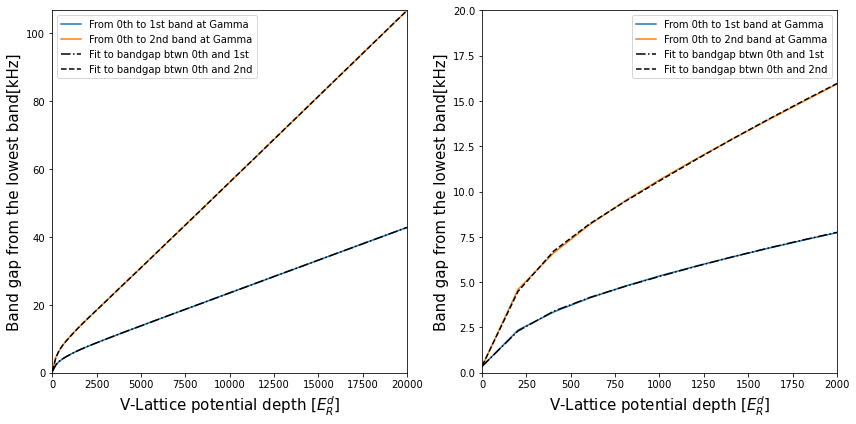

In [6]:
fig = plt.figure(figsize=[12,6])
ax1 = fig.add_subplot(1,2,1)
ax1.plot(v_list, bandGapAfterUnitConversion[::,0,q_gamma], label = 'From 0th to 1st band at Gamma')
ax1.plot(v_list, bandGapAfterUnitConversion[::,1,q_gamma], label = 'From 0th to 2nd band at Gamma')
ax1.plot(v_list,polyFitToBandgapBtwn0thand1st(v_list),c='black', linestyle='dashdot',label='Fit to bandgap btwn 0th and 1st')
ax1.plot(v_list,polyFitToBandgapBtwn0thand2nd(v_list),c='black', linestyle='dashed',label='Fit to bandgap btwn 0th and 2nd')
ax1.set_xlim([vLatticePotentialMin,vLatticePotentialMax])
ax1.set_ylim([0,np.max(bandGapAfterUnitConversion[::,1,q_gamma])])
ax1.set_xlabel(r"V-Lattice potential depth $[E_R^d]$", fontsize=15)
ax1.set_ylabel(r"Band gap from the lowest band[kHz]", fontsize=15)
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(v_list, bandGapAfterUnitConversion[::,0,q_gamma], label = 'From 0th to 1st band at Gamma')
ax2.plot(v_list, bandGapAfterUnitConversion[::,1,q_gamma], label = 'From 0th to 2nd band at Gamma')
ax2.plot(v_list,polyFitToBandgapBtwn0thand1st(v_list),c='black', linestyle='dashdot',label='Fit to bandgap btwn 0th and 1st')
ax2.plot(v_list,polyFitToBandgapBtwn0thand2nd(v_list),c='black', linestyle='dashed',label='Fit to bandgap btwn 0th and 2nd')
ax2.set_xlim([vLatticePotentialMin,2000])
ax2.set_ylim([0,20])
ax2.set_xlabel(r"V-Lattice potential depth $[E_R^d]$", fontsize=15)
ax2.set_ylabel(r"Band gap from the lowest band[kHz]", fontsize=15)
ax2.legend()

plt.tight_layout()
plt.show()

In [7]:
polyFitToBandgapBtwn0thand2nd(2000)

15.957190807864466

In [8]:
polyFitToBandgapBtwn0thand2nd.coef

array([ 2.06085644e-77, -3.65354299e-72,  2.89114731e-67, -1.32559285e-62,
        3.75319914e-58, -5.99362202e-54,  1.14063093e-50,  2.08343623e-45,
       -6.13473526e-41,  1.03266697e-36, -1.20835409e-32,  1.03797501e-28,
       -6.66039196e-25,  3.19456911e-21, -1.13344405e-17,  2.91533910e-14,
       -5.27193916e-11,  6.42368606e-08, -4.99360821e-05,  2.81954660e-02,
        3.71355098e-01])

In [9]:
y_list = v_list
z3 = np.polyfit(bandGapAfterUnitConversion[::,0,q_gamma],y_list,12)
polyFitToBandgapBtwn0thand1st2 = np.poly1d(z3)
z4 = np.polyfit(bandGapAfterUnitConversion[::,1,q_gamma], y_list,12)
polyFitToBandgapBtwn0thand2nd2 = np.poly1d(z4)

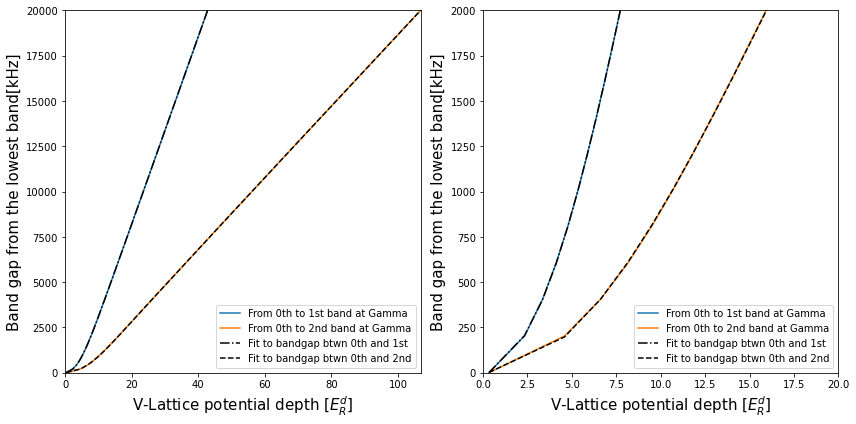

In [10]:
fig = plt.figure(figsize=[12,6])
ax1 = fig.add_subplot(1,2,1)
ax1.plot(bandGapAfterUnitConversion[::,0,q_gamma], v_list, label = 'From 0th to 1st band at Gamma')
ax1.plot(bandGapAfterUnitConversion[::,1,q_gamma], v_list, label = 'From 0th to 2nd band at Gamma')
ax1.plot(bandGapAfterUnitConversion[::,0,q_gamma], polyFitToBandgapBtwn0thand1st2(bandGapAfterUnitConversion[::,0,q_gamma]),c='black', linestyle='dashdot',label='Fit to bandgap btwn 0th and 1st')
ax1.plot(bandGapAfterUnitConversion[::,1,q_gamma], polyFitToBandgapBtwn0thand2nd2(bandGapAfterUnitConversion[::,1,q_gamma]),c='black', linestyle='dashed',label='Fit to bandgap btwn 0th and 2nd')
ax1.set_ylim([vLatticePotentialMin,vLatticePotentialMax])
ax1.set_xlim([0,np.max(bandGapAfterUnitConversion[::,1,q_gamma])])
ax1.set_xlabel(r"V-Lattice potential depth $[E_R^d]$", fontsize=15)
ax1.set_ylabel(r"Band gap from the lowest band[kHz]", fontsize=15)
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(bandGapAfterUnitConversion[::,0,q_gamma], v_list, label = 'From 0th to 1st band at Gamma')
ax2.plot(bandGapAfterUnitConversion[::,1,q_gamma], v_list, label = 'From 0th to 2nd band at Gamma')
ax2.plot(bandGapAfterUnitConversion[::,0,q_gamma], polyFitToBandgapBtwn0thand1st2(bandGapAfterUnitConversion[::,0,q_gamma]),c='black', linestyle='dashdot',label='Fit to bandgap btwn 0th and 1st')
ax2.plot(bandGapAfterUnitConversion[::,1,q_gamma], polyFitToBandgapBtwn0thand2nd2(bandGapAfterUnitConversion[::,1,q_gamma]),c='black', linestyle='dashed',label='Fit to bandgap btwn 0th and 2nd')
ax2.set_ylim([vLatticePotentialMin,2000])
ax2.set_xlim([0,20])
ax2.set_xlabel(r"V-Lattice potential depth $[E_R^d]$", fontsize=15)
ax2.set_ylabel(r"Band gap from the lowest band[kHz]", fontsize=15)
ax2.legend()

plt.tight_layout()
plt.show()

In [11]:
polyFitToBandgapBtwn0thand2nd2(25.35)

3884.0853467616685

In [12]:
polyFitToBandgapBtwn0thand2nd2.coef

array([-1.39177073e-17,  9.47087268e-15, -2.84273611e-12,  4.94780254e-10,
       -5.51879068e-08,  4.11079696e-06, -2.06186269e-04,  6.81281652e-03,
       -1.38023876e-01,  1.35059117e+00,  2.90054276e+00,  1.27007814e+01,
       -3.94961151e+00])